# 🔧 Tiền Xử Lý Dữ Liệu (Data Preprocessing)

## Mục tiêu:
- Xử lý missing values và giá trị 'N/A'
- Mã hóa các biến phân loại
- Chuẩn hóa và scaling dữ liệu
- Xử lý dữ liệu mất cân bằng
- Chia tách dữ liệu train/test

In [2]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import warnings
warnings.filterwarnings('ignore')

# Cấu hình hiển thị
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

## 1. Tải Dữ Liệu

In [3]:
# Tải dữ liệu
df = pd.read_csv('../data/raw/healthcare-dataset-stroke-data.csv.xls')

print("📊 THÔNG TIN DỮ LIỆU GỐC:")
print(f"Kích thước: {df.shape}")
print(f"Các cột: {list(df.columns)}")
print("\nMẫu dữ liệu:")
df.head()

📊 THÔNG TIN DỮ LIỆU GỐC:
Kích thước: (5110, 12)
Các cột: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']

Mẫu dữ liệu:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 2. Xử Lý Missing Values và Giá Trị 'N/A'

❌ KIỂM TRA MISSING VALUES:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

⚠️ Số giá trị 'N/A' trong BMI: 0

✅ Sau khi chuyển đổi, missing values trong BMI: 201


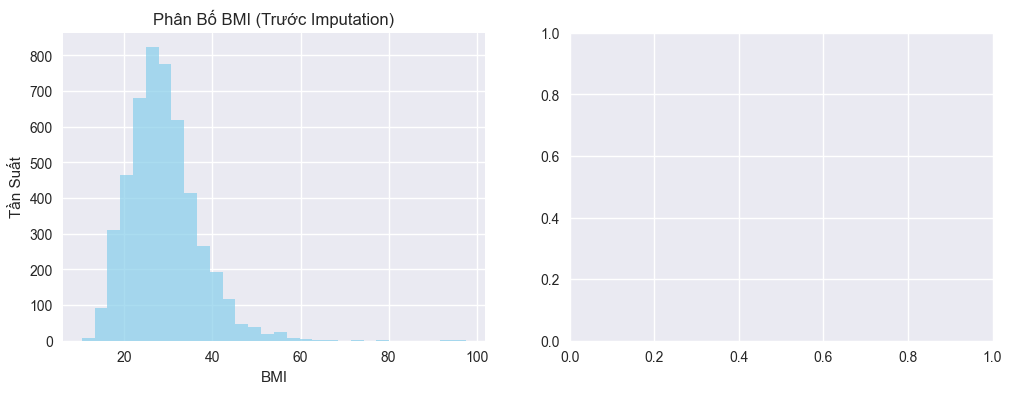

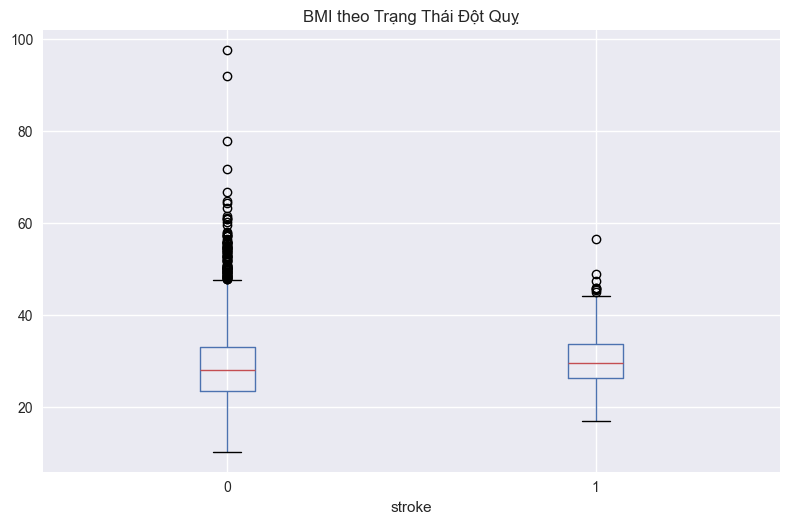


📊 THỐNG KÊ BMI:
count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64


In [4]:
# Kiểm tra missing values
print("❌ KIỂM TRA MISSING VALUES:")
print(df.isnull().sum())

# Kiểm tra giá trị 'N/A' trong BMI
na_count = (df['bmi'] == 'N/A').sum()
print(f"\n⚠️ Số giá trị 'N/A' trong BMI: {na_count}")

# Thay thế 'N/A' bằng NaN
df['bmi'] = df['bmi'].replace('N/A', np.nan)
df['bmi'] = pd.to_numeric(df['bmi'])

print(f"\n✅ Sau khi chuyển đổi, missing values trong BMI: {df['bmi'].isnull().sum()}")

# Phân tích phân bố BMI để quyết định phương pháp imputation
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['bmi'].dropna().hist(bins=30, alpha=0.7, color='skyblue')
plt.title('Phân Bố BMI (Trước Imputation)')
plt.xlabel('BMI')
plt.ylabel('Tần Suất')

plt.subplot(1, 2, 2)
df.boxplot(column='bmi', by='stroke')
plt.title('BMI theo Trạng Thái Đột Quỵ')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Thống kê BMI
print("\n📊 THỐNG KÊ BMI:")
print(df['bmi'].describe())

✅ Sau imputation, missing values trong BMI: 0


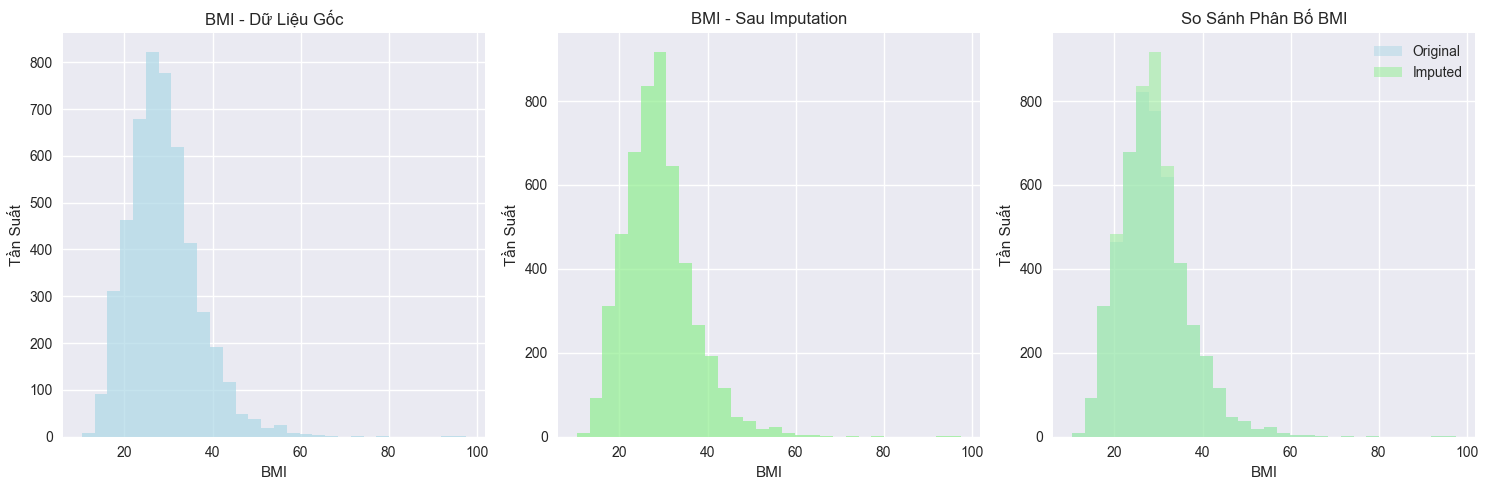

In [5]:
# Imputation BMI bằng median theo nhóm
# Tạo nhóm dựa trên gender, age_group và stroke status
df['age_group'] = pd.cut(df['age'], 
                        bins=[0, 18, 30, 45, 60, 75, 100], 
                        labels=['<18', '18-30', '30-45', '45-60', '60-75', '>75'])

# Imputation bằng median theo nhóm
df['bmi_imputed'] = df.groupby(['gender', 'age_group'])['bmi'].transform(
    lambda x: x.fillna(x.median())
)

# Nếu vẫn còn missing (do nhóm không có dữ liệu), dùng median tổng thể
df['bmi_imputed'] = df['bmi_imputed'].fillna(df['bmi'].median())

print(f"✅ Sau imputation, missing values trong BMI: {df['bmi_imputed'].isnull().sum()}")

# So sánh phân bố trước và sau imputation
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['bmi'].dropna().hist(bins=30, alpha=0.7, color='lightblue', label='Original')
plt.title('BMI - Dữ Liệu Gốc')
plt.xlabel('BMI')
plt.ylabel('Tần Suất')

plt.subplot(1, 3, 2)
df['bmi_imputed'].hist(bins=30, alpha=0.7, color='lightgreen', label='Imputed')
plt.title('BMI - Sau Imputation')
plt.xlabel('BMI')
plt.ylabel('Tần Suất')

plt.subplot(1, 3, 3)
df['bmi'].dropna().hist(bins=30, alpha=0.5, color='lightblue', label='Original')
df['bmi_imputed'].hist(bins=30, alpha=0.5, color='lightgreen', label='Imputed')
plt.title('So Sánh Phân Bố BMI')
plt.xlabel('BMI')
plt.ylabel('Tần Suất')
plt.legend()

plt.tight_layout()
plt.show()

# Cập nhật cột BMI
df['bmi'] = df['bmi_imputed']
df.drop(['bmi_imputed'], axis=1, inplace=True)

## 3. Feature Engineering

🔧 FEATURE ENGINEERING:
✅ Các features mới đã được tạo:
- bmi_category: Phân loại BMI
- glucose_category: Phân loại mức glucose
- risk_score: Điểm nguy cơ tổng hợp (0-5)
- age_bmi_interaction: Tương tác tuổi-BMI


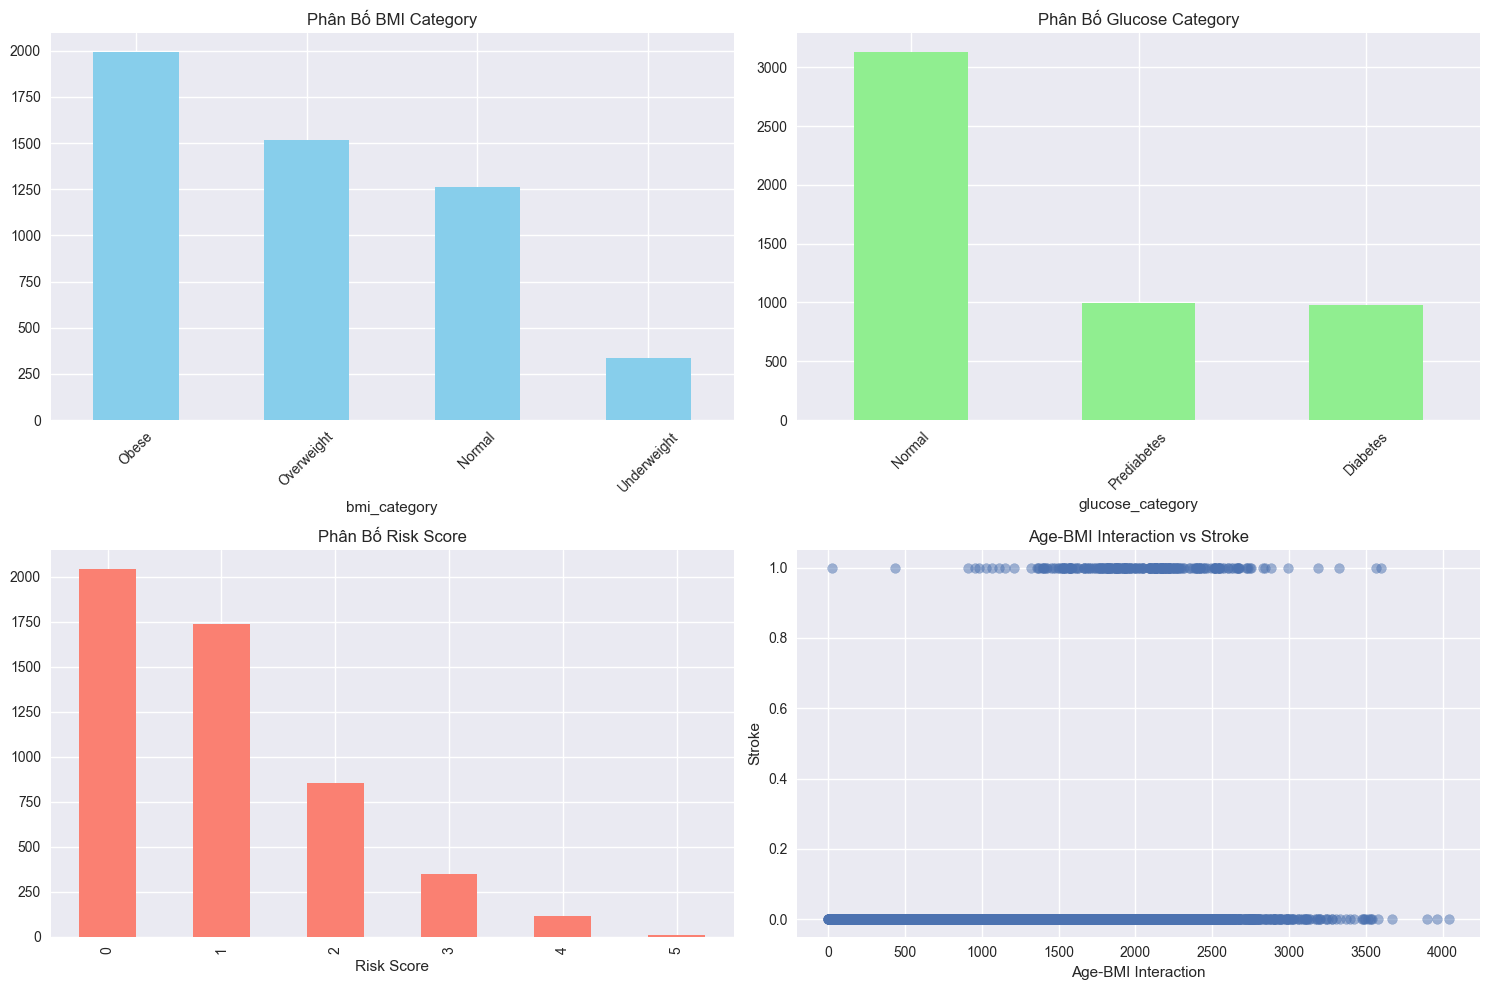

In [6]:
# Tạo các features mới
print("🔧 FEATURE ENGINEERING:")

# 1. BMI Categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df['bmi_category'] = df['bmi'].apply(categorize_bmi)

# 2. Glucose Level Categories
def categorize_glucose(glucose):
    if glucose < 100:
        return 'Normal'
    elif glucose < 126:
        return 'Prediabetes'
    else:
        return 'Diabetes'

df['glucose_category'] = df['avg_glucose_level'].apply(categorize_glucose)

# 3. Risk Score (tổng hợp các yếu tố nguy cơ)
df['risk_score'] = (df['age'] > 60).astype(int) + \
                   df['hypertension'] + \
                   df['heart_disease'] + \
                   (df['avg_glucose_level'] > 126).astype(int) + \
                   (df['bmi'] > 30).astype(int)

# 4. Age-BMI interaction
df['age_bmi_interaction'] = df['age'] * df['bmi']

print("✅ Các features mới đã được tạo:")
print("- bmi_category: Phân loại BMI")
print("- glucose_category: Phân loại mức glucose")
print("- risk_score: Điểm nguy cơ tổng hợp (0-5)")
print("- age_bmi_interaction: Tương tác tuổi-BMI")

# Hiển thị phân bố các features mới
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# BMI Category
df['bmi_category'].value_counts().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Phân Bố BMI Category')
axes[0,0].tick_params(axis='x', rotation=45)

# Glucose Category
df['glucose_category'].value_counts().plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Phân Bố Glucose Category')
axes[0,1].tick_params(axis='x', rotation=45)

# Risk Score
df['risk_score'].value_counts().sort_index().plot(kind='bar', ax=axes[1,0], color='salmon')
axes[1,0].set_title('Phân Bố Risk Score')
axes[1,0].set_xlabel('Risk Score')

# Age-BMI Interaction
axes[1,1].scatter(df['age_bmi_interaction'], df['stroke'], alpha=0.5)
axes[1,1].set_title('Age-BMI Interaction vs Stroke')
axes[1,1].set_xlabel('Age-BMI Interaction')
axes[1,1].set_ylabel('Stroke')

plt.tight_layout()
plt.show()

## 4. Mã Hóa Biến Phân Loại

In [7]:
# Chuẩn bị dữ liệu cho modeling
df_model = df.copy()

# Loại bỏ cột id và age_group (đã dùng để imputation)
df_model = df_model.drop(['id', 'age_group'], axis=1)

print("🔤 MÃ HÓA BIẾN PHÂN LOẠI:")

# Danh sách các biến phân loại
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 
                   'smoking_status', 'bmi_category', 'glucose_category']

# One-hot encoding
df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

print(f"✅ Kích thước sau encoding: {df_encoded.shape}")
print(f"Số features: {df_encoded.shape[1] - 1}")
print("\nCác cột mới:")
new_cols = [col for col in df_encoded.columns if col not in df_model.select_dtypes(include=[np.number]).columns]
print(new_cols[:10], '...' if len(new_cols) > 10 else '')

df_encoded.head()

🔤 MÃ HÓA BIẾN PHÂN LOẠI:
✅ Kích thước sau encoding: (5110, 24)
Số features: 23

Các cột mới:
['gender_Male', 'gender_Other', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked'] ...


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,risk_score,age_bmi_interaction,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,bmi_category_Obese,bmi_category_Overweight,bmi_category_Underweight,glucose_category_Normal,glucose_category_Prediabetes
0,67.0,0,1,228.69,36.6,1,4,2452.2,True,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False
1,61.0,0,0,202.21,29.6,1,2,1805.6,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False
2,80.0,0,1,105.92,32.5,1,3,2600.0,True,False,True,False,True,False,False,False,False,True,False,True,False,False,False,True
3,49.0,0,0,171.23,34.4,1,2,1685.6,False,False,True,False,True,False,False,True,False,False,True,True,False,False,False,False
4,79.0,1,0,174.12,24.0,1,3,1896.0,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False


## 5. Chia Tách Dữ Liệu

📊 CHIA TÁCH DỮ LIỆU:
Kích thước X: (5110, 23)
Kích thước y: (5110,)
Tỷ lệ stroke trong y: 0.0487

✅ KÍCH THƯỚC SAU CHIA TÁCH:
X_train: (4088, 23)
X_test: (1022, 23)
y_train: (4088,)
y_test: (1022,)

📈 TỶ LỆ STROKE:
Train set: 0.0487
Test set: 0.0489


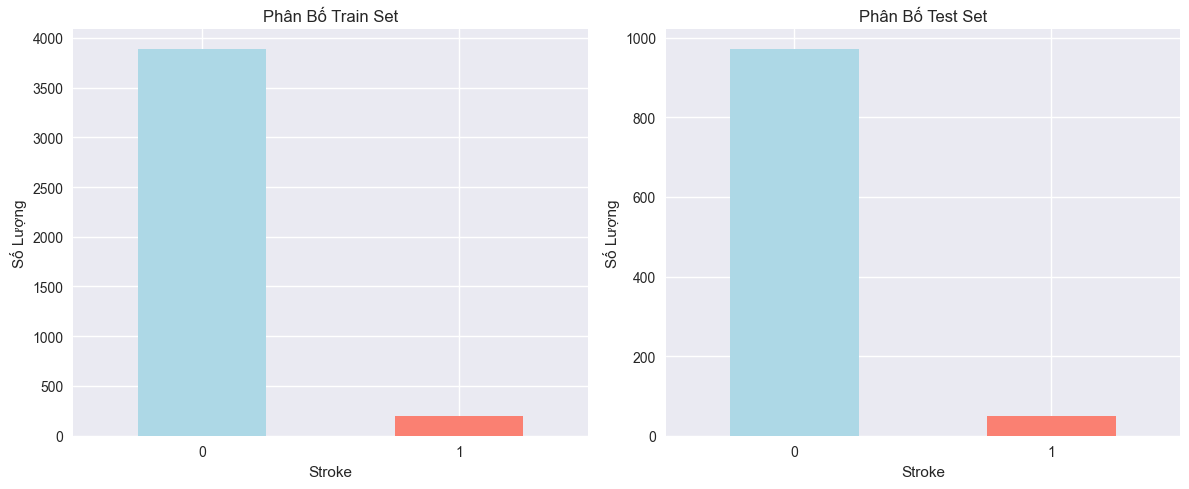

In [8]:
# Tách features và target
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

print("📊 CHIA TÁCH DỮ LIỆU:")
print(f"Kích thước X: {X.shape}")
print(f"Kích thước y: {y.shape}")
print(f"Tỷ lệ stroke trong y: {y.mean():.4f}")

# Chia train-test với stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✅ KÍCH THƯỚC SAU CHIA TÁCH:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

print(f"\n📈 TỶ LỆ STROKE:")
print(f"Train set: {y_train.mean():.4f}")
print(f"Test set: {y_test.mean():.4f}")

# Visualization phân bố
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

y_train.value_counts().plot(kind='bar', ax=axes[0], color=['lightblue', 'salmon'])
axes[0].set_title('Phân Bố Train Set')
axes[0].set_xlabel('Stroke')
axes[0].set_ylabel('Số Lượng')
axes[0].tick_params(axis='x', rotation=0)

y_test.value_counts().plot(kind='bar', ax=axes[1], color=['lightblue', 'salmon'])
axes[1].set_title('Phân Bố Test Set')
axes[1].set_xlabel('Stroke')
axes[1].set_ylabel('Số Lượng')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 6. Chuẩn Hóa Dữ Liệu

📏 CHUẨN HÓA DỮ LIỆU:
✅ Đã chuẩn hóa 23 features


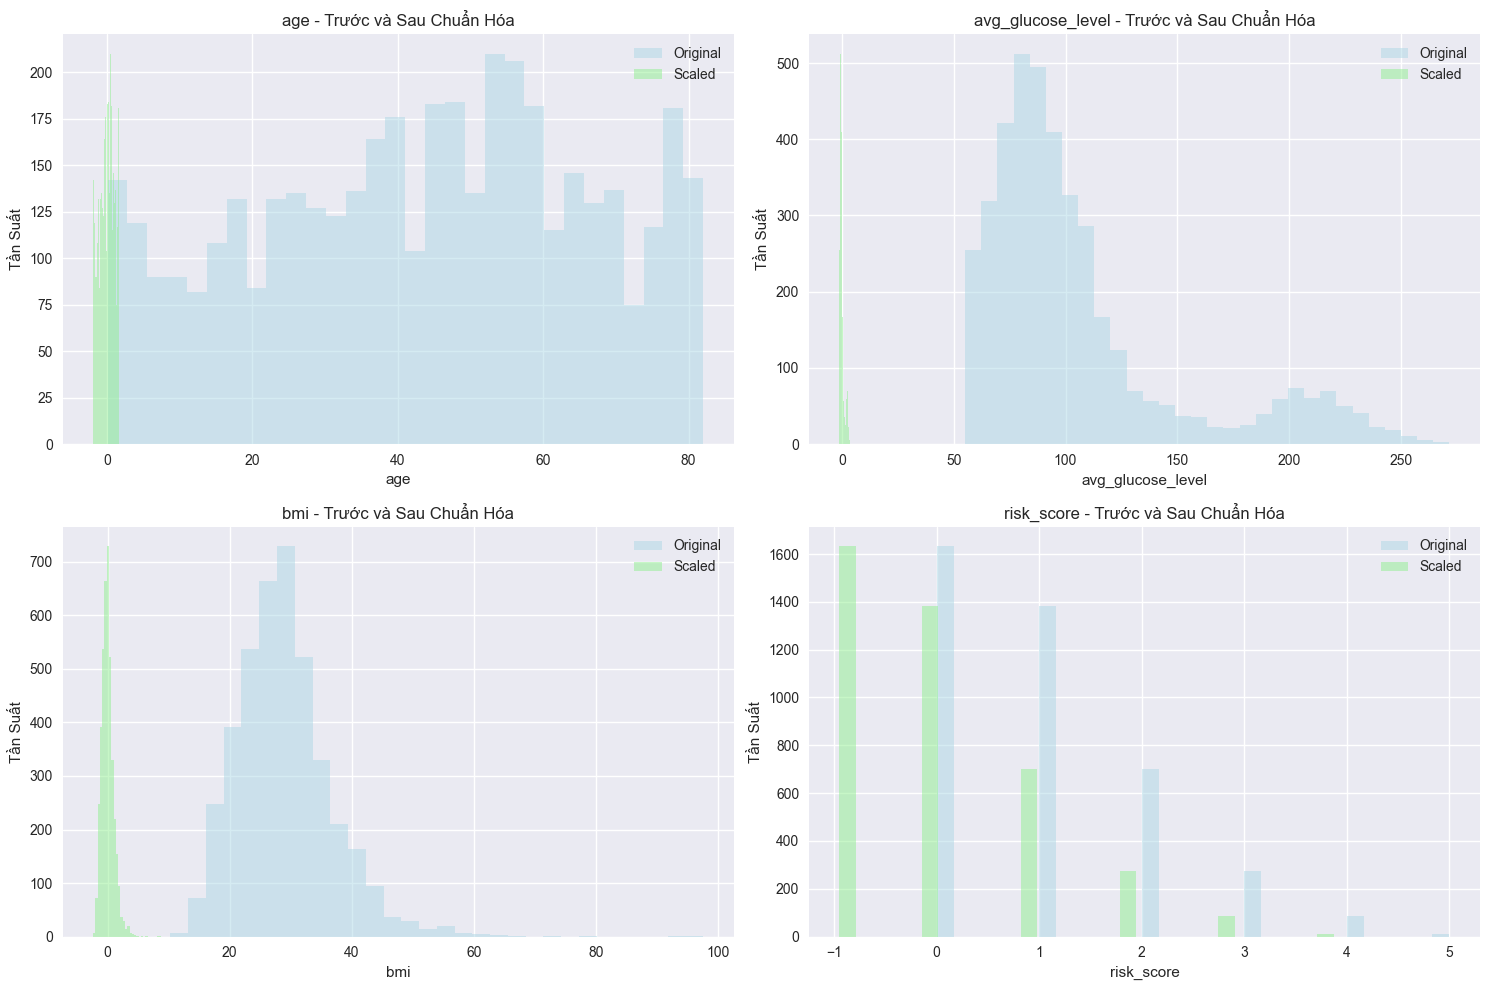


📊 THỐNG KÊ SAU CHUẨN HÓA (một số features):
                age  avg_glucose_level           bmi    risk_score
count  4.088000e+03       4.088000e+03  4.088000e+03  4.088000e+03
mean  -1.564306e-17       3.702192e-16  6.648302e-17 -3.476236e-18
std    1.000122e+00       1.000122e+00  1.000122e+00  1.000122e+00
min   -1.915251e+00      -1.131326e+00 -2.390228e+00 -9.466232e-01
25%   -7.680467e-01      -6.409288e-01 -6.688176e-01 -9.466232e-01
50%    7.288256e-02      -3.175881e-01 -9.715520e-02  1.697133e-02
75%    7.810336e-01       1.741352e-01  5.001999e-01  9.805659e-01
max    1.710482e+00       3.655421e+00  8.824632e+00  3.871349e+00


In [9]:
# Chuẩn hóa dữ liệu số
scaler = StandardScaler()

# Fit trên train set và transform cả train và test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Chuyển về DataFrame để dễ xử lý
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("📏 CHUẨN HÓA DỮ LIỆU:")
print(f"✅ Đã chuẩn hóa {X_train.shape[1]} features")

# So sánh phân bố trước và sau chuẩn hóa
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Chọn một số features để hiển thị
sample_features = ['age', 'avg_glucose_level', 'bmi', 'risk_score']

for i, feature in enumerate(sample_features):
    row, col = i // 2, i % 2
    
    # Trước chuẩn hóa
    axes[row, col].hist(X_train[feature], bins=30, alpha=0.5, label='Original', color='lightblue')
    
    # Sau chuẩn hóa
    axes[row, col].hist(X_train_scaled[feature], bins=30, alpha=0.5, label='Scaled', color='lightgreen')
    
    axes[row, col].set_title(f'{feature} - Trước và Sau Chuẩn Hóa')
    axes[row, col].legend()
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Tần Suất')

plt.tight_layout()
plt.show()

# Thống kê sau chuẩn hóa
print("\n📊 THỐNG KÊ SAU CHUẨN HÓA (một số features):")
print(X_train_scaled[sample_features].describe())

## 7. Xử Lý Dữ Liệu Mất Cân Bằng

⚖️ XỬ LÝ DỮ LIỆU MẤT CÂN BẰNG:
Phân bố gốc: {0: np.int64(3889), 1: np.int64(199)}
Tỷ lệ: 1:19.5

📊 SO SÁNH CÁC PHƯƠNG PHÁP:
Original        - Kích thước:  4088 - Phân bố: {0: np.int64(3889), 1: np.int64(199)} - Tỷ lệ: 1:19.5
SMOTE           - Kích thước:  7778 - Phân bố: {0: np.int64(3889), 1: np.int64(3889)} - Tỷ lệ: 1:1.0
Under Sampling  - Kích thước:   398 - Phân bố: {0: np.int64(199), 1: np.int64(199)} - Tỷ lệ: 1:1.0
SMOTEENN        - Kích thước:  6987 - Phân bố: {0: np.int64(3210), 1: np.int64(3777)} - Tỷ lệ: 1:0.8


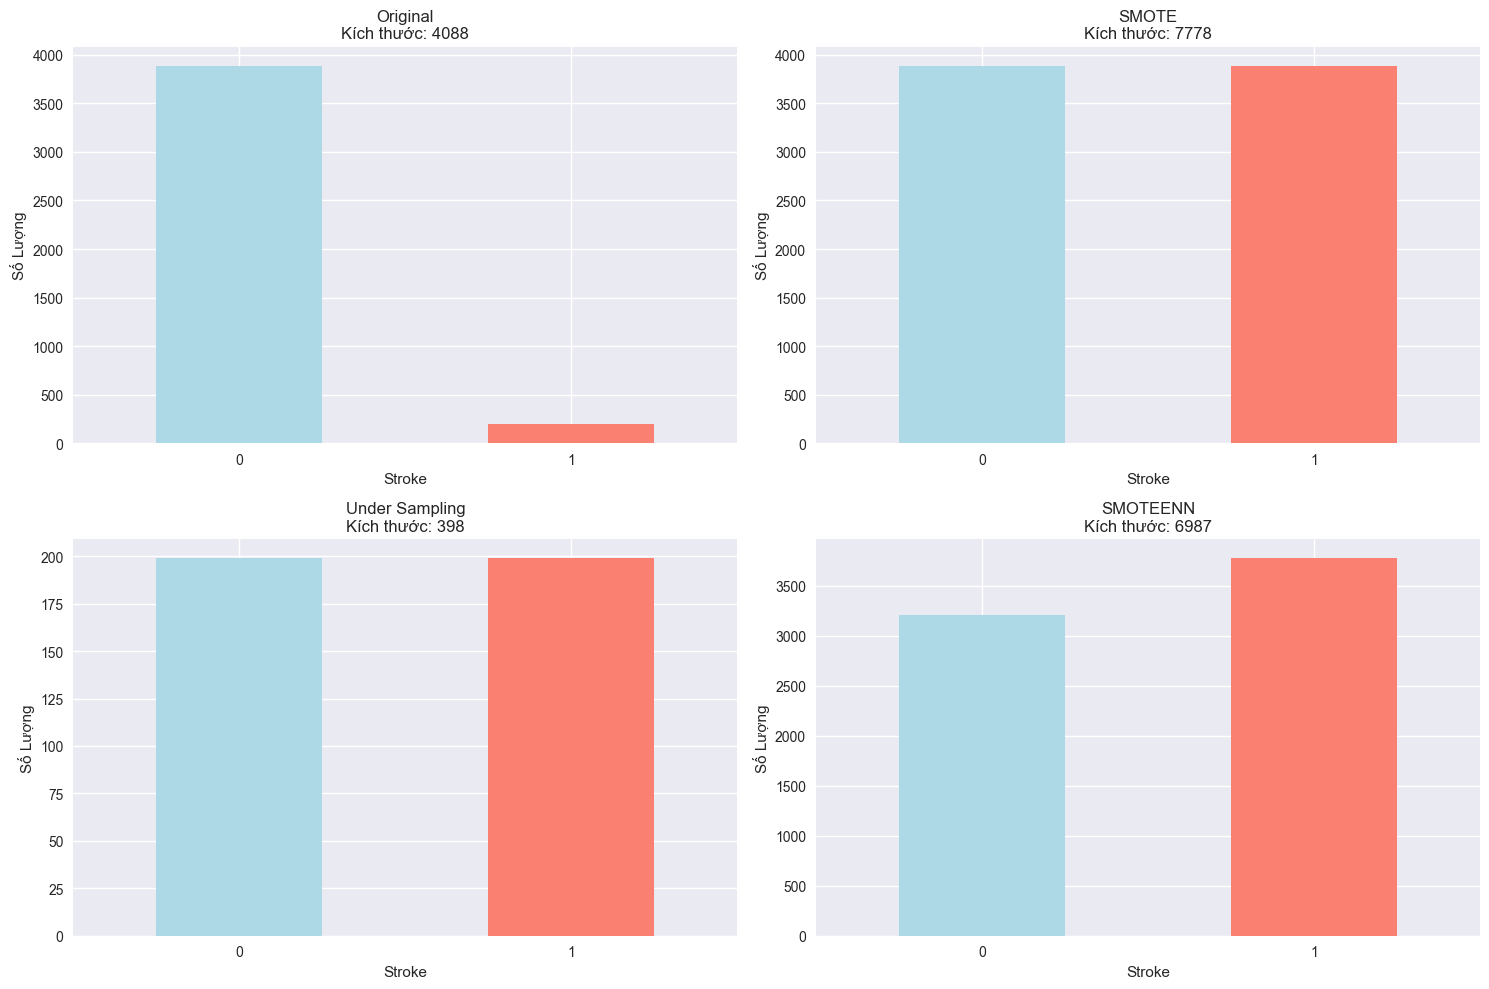

In [10]:
print("⚖️ XỬ LÝ DỮ LIỆU MẤT CÂN BẰNG:")

# Phân bố gốc
original_counts = y_train.value_counts()
print(f"Phân bố gốc: {dict(original_counts)}")
print(f"Tỷ lệ: 1:{original_counts[0]/original_counts[1]:.1f}")

# 1. SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# 2. Random Under Sampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train_scaled, y_train)

# 3. SMOTEENN (SMOTE + Edited Nearest Neighbours)
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train_scaled, y_train)

# So sánh các phương pháp
methods = {
    'Original': (X_train_scaled, y_train),
    'SMOTE': (X_train_smote, y_train_smote),
    'Under Sampling': (X_train_under, y_train_under),
    'SMOTEENN': (X_train_smoteenn, y_train_smoteenn)
}

print("\n📊 SO SÁNH CÁC PHƯƠNG PHÁP:")
for method, (X, y) in methods.items():
    counts = pd.Series(y).value_counts().sort_index()
    ratio = counts[0] / counts[1] if counts[1] > 0 else 'inf'
    print(f"{method:15} - Kích thước: {X.shape[0]:5} - Phân bố: {dict(counts)} - Tỷ lệ: 1:{ratio:.1f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, (method, (X, y)) in enumerate(methods.items()):
    counts = pd.Series(y).value_counts().sort_index()
    counts.plot(kind='bar', ax=axes[i], color=['lightblue', 'salmon'])
    axes[i].set_title(f'{method}\nKích thước: {X.shape[0]}')
    axes[i].set_xlabel('Stroke')
    axes[i].set_ylabel('Số Lượng')
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 8. Lưu Dữ Liệu Đã Xử Lý

In [11]:
# Lưu các version dữ liệu khác nhau
import pickle
import os

# Tạo thư mục processed nếu chưa có
os.makedirs('../data/processed', exist_ok=True)

# Lưu dữ liệu gốc (đã xử lý missing values)
data_original = {
    'X_train': X_train_scaled,
    'X_test': X_test_scaled,
    'y_train': y_train,
    'y_test': y_test,
    'scaler': scaler,
    'feature_names': list(X_train.columns)
}

# Lưu dữ liệu SMOTE
data_smote = {
    'X_train': X_train_smote,
    'X_test': X_test_scaled,
    'y_train': y_train_smote,
    'y_test': y_test,
    'scaler': scaler,
    'feature_names': list(X_train.columns)
}

# Lưu dữ liệu Under Sampling
data_under = {
    'X_train': X_train_under,
    'X_test': X_test_scaled,
    'y_train': y_train_under,
    'y_test': y_test,
    'scaler': scaler,
    'feature_names': list(X_train.columns)
}

# Lưu dữ liệu SMOTEENN
data_smoteenn = {
    'X_train': X_train_smoteenn,
    'X_test': X_test_scaled,
    'y_train': y_train_smoteenn,
    'y_test': y_test,
    'scaler': scaler,
    'feature_names': list(X_train.columns)
}

# Lưu files
with open('../data/processed/data_original.pkl', 'wb') as f:
    pickle.dump(data_original, f)

with open('../data/processed/data_smote.pkl', 'wb') as f:
    pickle.dump(data_smote, f)

with open('../data/processed/data_under.pkl', 'wb') as f:
    pickle.dump(data_under, f)

with open('../data/processed/data_smoteenn.pkl', 'wb') as f:
    pickle.dump(data_smoteenn, f)

print("💾 ĐÃ LƯU DỮ LIỆU:")
print("✅ data_original.pkl - Dữ liệu gốc (đã chuẩn hóa)")
print("✅ data_smote.pkl - Dữ liệu SMOTE")
print("✅ data_under.pkl - Dữ liệu Under Sampling")
print("✅ data_smoteenn.pkl - Dữ liệu SMOTEENN")

# Lưu thêm processed dataframe
df_model.to_csv('../data/processed/stroke_data_processed.csv', index=False)
print("✅ stroke_data_processed.csv - DataFrame đã xử lý")

💾 ĐÃ LƯU DỮ LIỆU:
✅ data_original.pkl - Dữ liệu gốc (đã chuẩn hóa)
✅ data_smote.pkl - Dữ liệu SMOTE
✅ data_under.pkl - Dữ liệu Under Sampling
✅ data_smoteenn.pkl - Dữ liệu SMOTEENN
✅ stroke_data_processed.csv - DataFrame đã xử lý


## 9. Tóm Tắt Preprocessing

In [12]:
print("""📋 TÓM TẮT QUÁ TRÌNH TIỀN XỬ LÝ:

🔧 CÁC BƯỚC ĐÃ THỰC HIỆN:
1. ✅ Xử lý missing values trong BMI (201 giá trị 'N/A')
   - Sử dụng median imputation theo nhóm (gender + age_group)
   
2. ✅ Feature Engineering:
   - BMI categories (Underweight, Normal, Overweight, Obese)
   - Glucose categories (Normal, Prediabetes, Diabetes)
   - Risk score (0-5 điểm)
   - Age-BMI interaction
   
3. ✅ Mã hóa biến phân loại:
   - One-hot encoding cho tất cả categorical variables
   - Tổng cộng {} features sau encoding
   
4. ✅ Chia tách dữ liệu:
   - Train: {} samples
   - Test: {} samples
   - Stratified split để giữ tỷ lệ stroke
   
5. ✅ Chuẩn hóa dữ liệu:
   - StandardScaler cho tất cả features
   - Fit trên train, transform trên test
   
6. ✅ Xử lý mất cân bằng dữ liệu:
   - SMOTE: {} samples
   - Under Sampling: {} samples
   - SMOTEENN: {} samples

📊 DỮ LIỆU CUỐI CÙNG:
- Features: {} (sau encoding)
- Train samples: {} (original) / {} (SMOTE)
- Test samples: {}
- Tỷ lệ stroke: {:.2%} (original) / 50% (SMOTE)

📁 FILES ĐÃ LƯU:
- data_original.pkl: Dữ liệu gốc đã xử lý
- data_smote.pkl: Dữ liệu SMOTE
- data_under.pkl: Dữ liệu Under Sampling
- data_smoteenn.pkl: Dữ liệu SMOTEENN
- stroke_data_processed.csv: DataFrame đã xử lý

🚀 SẴN SÀNG CHO MODELING!
""".format(
    X_train.shape[1],
    X_train.shape[0],
    X_test.shape[0],
    X_train_smote.shape[0],
    X_train_under.shape[0],
    X_train_smoteenn.shape[0],
    X_train.shape[1],
    X_train.shape[0],
    X_train_smote.shape[0],
    X_test.shape[0],
    y_train.mean()
))

📋 TÓM TẮT QUÁ TRÌNH TIỀN XỬ LÝ:

🔧 CÁC BƯỚC ĐÃ THỰC HIỆN:
1. ✅ Xử lý missing values trong BMI (201 giá trị 'N/A')
   - Sử dụng median imputation theo nhóm (gender + age_group)

2. ✅ Feature Engineering:
   - BMI categories (Underweight, Normal, Overweight, Obese)
   - Glucose categories (Normal, Prediabetes, Diabetes)
   - Risk score (0-5 điểm)
   - Age-BMI interaction

3. ✅ Mã hóa biến phân loại:
   - One-hot encoding cho tất cả categorical variables
   - Tổng cộng 23 features sau encoding

4. ✅ Chia tách dữ liệu:
   - Train: 4088 samples
   - Test: 1022 samples
   - Stratified split để giữ tỷ lệ stroke

5. ✅ Chuẩn hóa dữ liệu:
   - StandardScaler cho tất cả features
   - Fit trên train, transform trên test

6. ✅ Xử lý mất cân bằng dữ liệu:
   - SMOTE: 7778 samples
   - Under Sampling: 398 samples
   - SMOTEENN: 6987 samples

📊 DỮ LIỆU CUỐI CÙNG:
- Features: 23 (sau encoding)
- Train samples: 4088 (original) / 7778 (SMOTE)
- Test samples: 1022
- Tỷ lệ stroke: 4.87% (original) / 50% (S